In [16]:

import torch
from torch.utils.data import Dataset
import numpy as np
import cv2
import matplotlib.pyplot as plt





In [17]:
COLORS = ['#F44336',"#E91E63",'#9C27B0','#673AB7','#3F51B5','#2196F3','#03A9F4','#00BCD4','#4CAF50',
 '#8BC34A','#CDDC39','#FFEB3B','#FFC107','#FF9800','#FF5722']


r_min = 12
r_max = 36
line_width_min = 2
line_width_max = 4
background_intensity = 30.0 / 255.0

def hex2rgb(h):
    h = h.lstrip('#')
    return tuple(int(h[i:i+2], 16) for i in (0, 2 ,4))

def DrawRandomCircle(img,segments,r_min,r_max,alpha):
    color = hex2rgb( np.random.choice(COLORS) )
    t = np.random.random()
    r = int(t * r_min + (1-t) * r_max)
    ti = np.random.random()
    tj = np.random.random()
    i = int(ti*img.shape[0])
    j = int(tj*img.shape[1])
    canvas = img.copy()
    cv2.circle(canvas,(i,j), r, color, -1)
    cv2.circle(segments,(i,j), r, (1,0,0), -1)
    img = cv2.addWeighted(img, 1.0 - alpha, canvas, alpha, 0, img )
    box  = [i-r,j-r,2*r,2*r]
    return img,segments,box

def DrawRandomSquare(img,segments,r_min,r_max,alpha):
    color = hex2rgb( np.random.choice(COLORS) )
    t = np.random.random()
    r = int(t * r_min + (1-t) * r_max)
    i = int(np.random.random()*img.shape[0])
    j = int(np.random.random()*img.shape[1])
    theta = np.pi * np.random.random()
    ri = r*np.cos(theta)
    rj = r*np.sin(theta) 
    pts = [(ri,rj),(-rj,ri),(-ri,-rj),(rj,-ri) ]
    pts = [(i+y,j+x) for (y,x) in pts]
    pts = np.array(pts, np.int32)
    pts = pts.reshape((-1,1,2))
    canvas = img.copy()
    cv2.fillPoly(canvas,[pts],color)
    cv2.fillPoly(segments,[pts],(0,1,0))
    img = cv2.addWeighted(img, 1.0 - alpha, canvas, alpha, 0, img )
    box = [min(pts[:,:,0])[0],min(pts[:,:,1])[0], max(pts[:,:,0])[0]-min(pts[:,:,0])[0], max(pts[:,:,1])[0] - min(pts[:,:,1])[0] ]
    return img,segments,box

def DrawRandomLine(img,segments,line_width_min,line_width_max,alpha):
    color = hex2rgb( np.random.choice(COLORS) )
    t = np.random.random()
    line_width = int(t * line_width_min + (1-t) * line_width_max)
    i1 = int(np.random.random()*img.shape[0])
    j1 = int(np.random.random()*img.shape[1])
    i2 = int(np.random.random()*img.shape[0])
    j2 = int(np.random.random()*img.shape[1])
    canvas = img.copy()
    cv2.line(canvas,(i1,j1),(i2,j2),color,line_width)
    cv2.line(segments,(i1,j1),(i2,j2),(0,0,1),line_width)
    img = cv2.addWeighted(img, 1.0 - alpha, canvas, alpha, 0, img )
    pts = np.asarray([(i1,j1),(i2,j2)])
    box = [min(pts[:,0]),min(pts[:,1]), max(pts[:,0])-min(pts[:,0]), max(pts[:,1]) - min(pts[:,1]) ]
    return img,segments,box

def generateSegmentation(canvas_size, n_max,data_size, alpha = 0.5, noise_types=[]):
    canvas = background_intensity * np.ones((data_size,canvas_size,canvas_size,3))
    segments = np.zeros((data_size,canvas_size,canvas_size,3))
    boxes = []
    labels = []
    for i in range(data_size):
#         for _ in range(np.random.choice(range(n_max))):
#             canvas[i],segments[i],b = DrawRandomCircle(canvas[i],segments[i],r_min,r_max,alpha)
#             boxes += [b]
#             labels += [1]
        for _ in range(np.random.choice(range(n_max))):
            canvas[i],segments[i],b = DrawRandomSquare(canvas[i],segments[i],r_min,r_max,alpha)
            boxes += [b]
            labels += [2]
        for _ in range(np.random.choice(range(n_max))):
            canvas[i],segments[i],b = DrawRandomLine(canvas[i],segments[i],line_width_min,line_width_max,alpha)
            boxes += [b]
            labels += [3]
        for t in noise_types:
            canvas[i] = noisy(t,canvas[i])
    return canvas,segments, labels, boxes

def stackSegments(segments):
    canvas = np.zeros((segments.shape[:3]))
    canvas += 1 * segments[:,:,:,0]
    canvas += 2 * segments[:,:,:,1]
    canvas += 3 * segments[:,:,:,2]
    return canvas



In [18]:
class SimpleSegmentationDataset(Dataset):
    """A simple dataset for image segmentation purpose"""
    def __init__(self, patch_size, n_max, alpha =1.0,virtual_size=1000):
        self.virtual_size = virtual_size
        self.patch_size = patch_size
        self.n_max = n_max
        self.alpha = alpha


    def __len__(self):
        return self.virtual_size

    def __getitem__(self):
        x,y,_,_ = generateSegmentation(self.patch_size, self.n_max,self.virtual_size, self.alpha)
#         x = x.transpose([2,0,1])

        y = stackSegments(y)
        y=(np.arange(y.max()) == y[...,None]-1).astype(int)
        return x,y
    


In [19]:
def draw_input(img, title=None):

    plt.title(title, fontsize=20)
    plt.imshow(img)
    plt.show()
    
def draw_label(img, title=None):
    img=np.argmax(img,2)
    plt.title(title, fontsize=20)
    plt.imshow(img)
    plt.show()

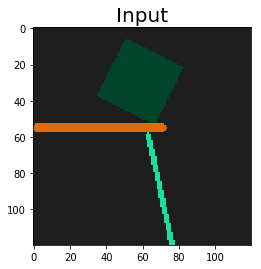

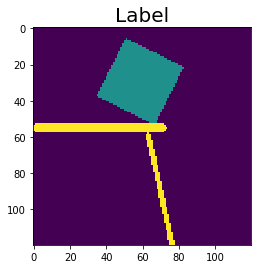

In [20]:
if __name__ == '__main__':

    segmentation_dataset=SimpleSegmentationDataset(120,4,virtual_size=200)
    test_x,test_y=segmentation_dataset.__getitem__()
    print(test_y.shape)
    draw_input(test_x[3],'Input')
    draw_label(test_y[3],'Label')
#     a = np.array([1, 0, 3])
#     b = np.zeros((3, 4))
#     b[np.arange(3), a] = 1
#     print(b)
    